# Creating custom datablocks for 3D images and fastai

In [1]:
# export
# default_exp data

import SimpleITK as sitk
import re
import pathlib
import torchvision

from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

!ln -s ../faimed3d/ faimed3d

In [2]:
# export
from faimed3d.basics import *
from faimed3d.augment import *


## Get data paths and labels

Data is divided into a train, valid and test dataset of different patients, which either have prostate cancer or are healthy. 
Each patient has three MRI sequences: T2, T1map and ADC. These sequences differ in number of slices and resolution. 

At first the paths to the data are specified: 

In [3]:
train = pathlib.Path('../../dl-prostate-mapping/data/train')
valid = pathlib.Path('../../dl-prostate-mapping/data/valid')
test = pathlib.Path('../../dl-prostate-mapping/data/test')

At the moment, I am only interested into the DICOM data, not in the NIfTI segmentations. 

In [4]:
train_files = list(train.rglob('DICOM'))
valid_files = list(valid.rglob('DICOM'))
test_files = list(test.rglob('DICOM'))

To reduce complexity of the data, only the T2 map will be used for the first runs. 

In [5]:
# take only T2 and T1 images for noe
subset_train =[]
for f in train_files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_train.append(Path(m.string))
        
subset_valid =[]
for f in valid_files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_valid.append(Path(m.string))
        
subset_test = []
for f in test_files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_test.append(Path(m.string))

If the patient has prostate cancer or not, can be extracted from the file path. 

In [6]:
labels = ['Gesund', 'ProstataCa']
def label_func(fn): return re.findall(r'(Gesund|ProstataCa)', str(fn))[0]

In [7]:
# export
class ScaleDicom(DisplayedTransform):
    "Transforms a TensorDicom3D volume to float and normalizes the data"
    def __init__(self, div=None, div_mask=1): store_attr()
    
    def encodes(self, x:(TensorDicom3D, TensorMask3D)):
        
        if isinstance(x, TensorMask3D): return x
        
        if self.div is None: 
            return normalize(x.hist_scaled()).float()
        else:
            return (x.hist_scaled()/div).float()
    

In [8]:
# export
def ImageBlock3D(cls=TensorDicom3D):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=ScaleDicom)

## Dataloaders for image classification problems

In [9]:
mris = DataBlock(
    blocks = (ImageBlock3D(cls=TensorDicom3D), 
              CategoryBlock),
    get_x = lambda x: x,
    get_y = label_func, 
    item_tfms = ResizeCrop3D(crop_by = (0., 0.1, 0.1), resize_to = (20, 150, 150), perc_crop = True),
    batch_tfms = [
        *aug_transforms_3d(), 
        RandomCrop3D(((3, 2), (25,25), (25,25)), (0, 25, 25)), 
        PseudoColor],
    splitter = RandomSplitter())

In [10]:
dls = mris.dataloaders(subset_train+subset_valid, 
                       batch_size = 16, 
                       num_workers = 0
                      )
dls.valid.bs = 16 # defaults to 64 and will cause Cuda out of Memory errors

In [11]:
def show_batch_3d(dls, max_n=9, **kwargs):
    "Workarround, until implemented into dls as dls.show_batch_3d()"
    xb, yb = dls.one_batch()
    xb.show(**kwargs)

/home/bressekk/Documents/faimed3d/nbs/faimed3d/basics.py:75: UserWarning: Object is not a rank 3 tensor but a rank 4 tensor. Assuming the 1st dimension is a (fake) color channel it will be removed
  warn(w)


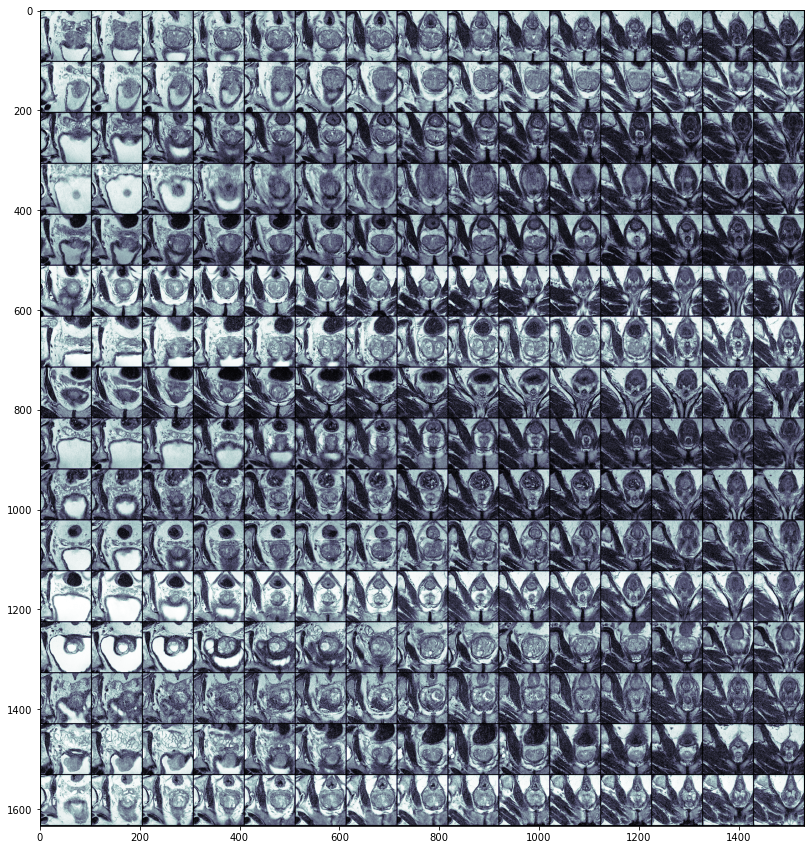

In [12]:
show_batch_3d(dls, axis = 0, nrow = 15)

In [13]:
dls.after_item

Pipeline: ResizeCrop3D -- {'crop_by': (0.0, 0.1, 0.1), 'resize_to': (20, 150, 150), 'perc_crop': True, 'p': 1} -> ToTensor

In [14]:
dls.after_batch

Pipeline: ScaleDicom -- {'div': None, 'div_mask': 1} -> RandomWarp3D -- {'p': 0.1} -> RandomDihedral3D -- {'p': 0.1} -> RandomBrightness3D -- {'p': 0.1} -> RandomContrast3D -- {'p': 0.1} -> RandomNoise3D -- {'p': 0.1} -> RandomRotate3DBy -- {'p': 0.1} -> RandomFlip3D -- {'p': 0.1} -> RandomRotate3D -- {'p': 0.1} -> RandomCrop3D -- {'p': 1} -> PseudoColor -- {'p': 1}

## 3D Segmentation Problem

In [15]:
segmentation_train = [(p.parent/'Annotation').ls()[0] for p in subset_train]

In [16]:
len(subset_train)  == len(segmentation_train)

True

In [17]:
# export 
class AddMaskCodes3D(AddMaskCodes):
    "Add the code metadata to a `TensorMask`"

    def decodes(self, o:TensorMask3D):
        o = o.int()
        if self.codes is not None: o._meta = {'codes': self.codes}
        return o

def MaskBlock3D(codes = None):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=TensorMask3D.create, item_tfms=AddMaskCodes3D(codes=codes),  batch_tfms=ScaleDicom)


In [18]:
# export
@patch
def clamp_to_range(x:TensorMask3D, lwr, upr):
    return torch.clamp(x, lwr, upr)    

class ClampMask3D(RandTransform):
    def __init__(self, lwr=0,upr=1,p=1): 
        super().__init__(p=p)
        self.lwr=lwr
        self.upr=upr
        
    def encodes(self, x:TensorMask3D): 
        x = x.clamp_to_range(self.lwr, self.upr)
        return x if x.device.type == 'cpu' else x.cuda()

In [19]:
mris = DataBlock(
    blocks = (ImageBlock3D(cls=TensorDicom3D), 
              MaskBlock3D(codes = ['void', "peripheral", 'transitional', 'cancer'])),
    get_x = lambda x: x[0],
    get_y = lambda x: x[1], 
    item_tfms = ResizeCrop3D(crop_by = (0.1, 0.15, 0.15), resize_to = (20, 150, 150), perc_crop = True),
    batch_tfms = [
        *aug_transforms_3d(p_all=0.25, do_rotate_by = False), 
        RandomCrop3D(((1, 1), (25,25), (25,25)), (1, 10, 10)), 
        ClampMask3D,
        PseudoColor],
    splitter = RandomSplitter())

In [20]:
d = pd.DataFrame({'image' : subset_train, 
                  'mask' : segmentation_train})

In [21]:
dls = mris.dataloaders(d, 
                       batch_size = 8, 
                       num_workers = 0,
                      )
dls.valid.bs = 8 # defaults to 64 and will cause Cuda out of Memory errors

The show_batch_3d function needs to be adapted to additionally show the masks

In [22]:
# export
def show_batch_3d(dls, max_n=9, with_mask=False, alpha_mask=0.3, figsize = (15, 15), **kwargs):
    "Workarround, until implemented into dls as dls.show_batch_3d()"
    xb, yb = dls.one_batch()
    xb.show(figsize=figsize)
    if with_mask: yb.show(add_to_existing = True, alpha = alpha_mask, cmap = 'jet', figsize=figsize)    

When displaying the masks it may occure, that Nifti images are rotated and do not fit the original DICOM. Most likely it is due to different frames of reference. 
in Simple-ITK it is LPS, while NIfTI and FSL use RAS, so those matrices are the same after accounting for frame of reference (taken and adapted from https://discourse.itk.org/t/nifti-orientation-issues/431).
So, luckly the malrotations are systematic and can be scripted.

```python
    def convert(fn):

        if 'Gesund' in fn: return # healthy patients were already flipped once
        im = sitk.ReadImage(fn)
        arr = sitk.GetArrayFromImage(im)
        arr = np.rot90(arr, 0)
        arr = np.flip(arr, 1)
        im2 = sitk.GetImageFromArray(arr)

        for k in im.GetMetaDataKeys(): # Copy meta data from original image before overwriting it. 
            im2.SetMetaData(k, im.GetMetaData(k))

        sitk.WriteImage(im2, fn)
        return im2
    
    
    for s in segmentation_train: 
    convert(str(s))
````

/home/bressekk/Documents/faimed3d/nbs/faimed3d/basics.py:75: UserWarning: Object is not a rank 3 tensor but a rank 4 tensor. Assuming the 1st dimension is a (fake) color channel it will be removed
  warn(w)


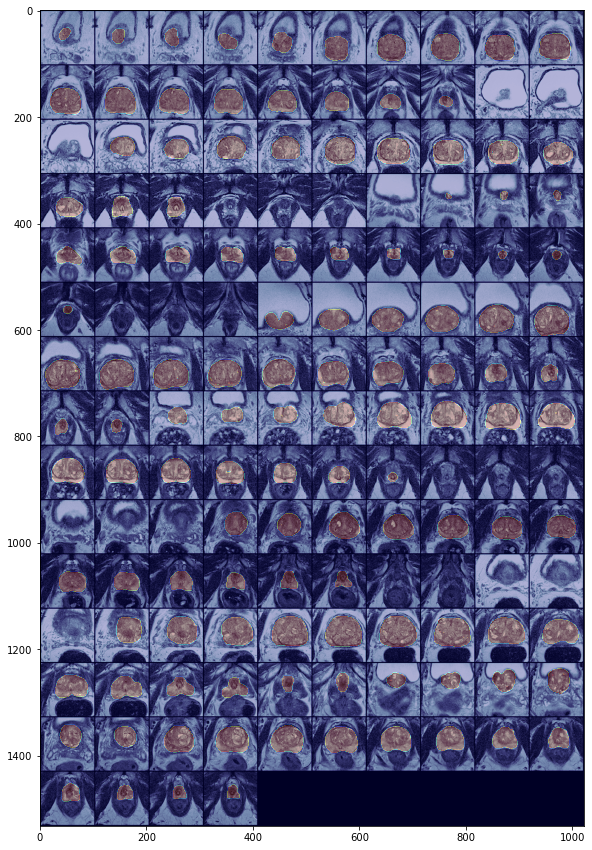

In [23]:
show_batch_3d(dls, with_mask=True, nrow = 10)